# The Transport Equation #

In this example, we solve the transport equation 

\begin{align*}
-\varepsilon\Delta u+\boldsymbol{b}\cdot\boldsymbol{\nabla}u & =f\qquad\text{ in }\Omega\\
u & =u_{0}\qquad\text{on }\partial\Omega,
\end{align*}
with $\varepsilon=0.1$, $\boldsymbol{b}=[1,1]^{T}$, and $f=1$ over square
$\Omega=[-1,1]^{2}$ with homogeneous Dirichlet BC.

### Standard Finite Elements ###

With the standard finite elements, the variational form is:
\[
\int_{\Omega}\varepsilon\boldsymbol{\nabla}u\cdot\boldsymbol{\nabla}v+\boldsymbol{b}\cdot\boldsymbol{\nabla}u\,v\,\text{d}\boldsymbol{x}=\int_{\Omega}f\,v\,\text{d}\boldsymbol{x}
\]

### FEniCS implementation ##

Load FEniCS modules.

In [1]:
from fenics import *
from mshr import *

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

Define functions for solving the transport problem in 2-D.

In [2]:
def u0_boundary(x, on_boundary):
    return on_boundary

def solve_transport_2dfem(n, epsilon):
    # Construct the mesh    
    domain = Rectangle(Point(-1, -1), Point(1,1))
    mesh = generate_mesh(domain,n)

    # Define trial and test functions
    V = FunctionSpace(mesh, 'P', 1)
    u = TrialFunction(V)
    v = TestFunction(V)

    f = Constant(1.)
    b = Constant((1., 1.))

    # Define boundary conditions
    u0 = Constant(0)
    bc = DirichletBC(V, u0, u0_boundary)
    
    # Define variational form
    a = epsilon * dot(grad(u), grad(v)) * dx + dot(b, grad(u)) * v * dx
    L = f * v * dx

    u = Function(V)
    solve(a == L, u, bc)
    
    return u

Solve the problem and plot the solution in 2-D and also the curve along diagonal.

In [3]:
def extract_diagonal(u):
    # Curve plot along diagonal
    tol = 0.01  # avoid hitting points outside the domain
    y = np.linspace(-1 + tol, 1 - tol, 101)
    points = [(y_, y_) for y_ in y]  # 2D points
    u_line = np.array([u(point) for point in points])
    
    return y, u_line

When $h<\varepsilon$, the solution is stable.

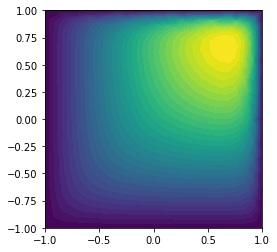

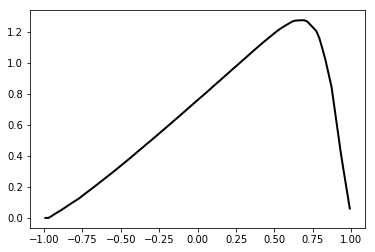

In [4]:
u = solve_transport_2dfem(n=20, epsilon=0.1)
plot(u)

y, u_line = extract_diagonal(u)
plt.figure()
plt.plot(y, u_line, 'k', linewidth=2)

However, when $h>\epsilon$, the solution is oscillatory.

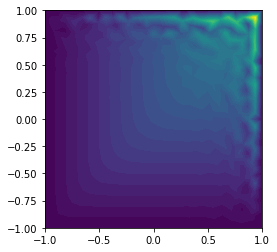

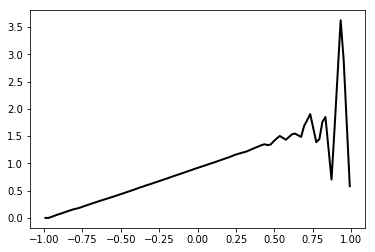

In [5]:
u = solve_transport_2dfem(n=20, epsilon=0.01)
plot(u)

y, u_line = extract_diagonal(u)
plt.figure()
plt.plot(y, u_line, 'k', linewidth=2)

This can also be seen in 1-D.

In [6]:
def solve_transport_1dfem(n, epsilon):
    # Construct the mesh
    mesh = IntervalMesh(n, -1, 1)
    
    f = Constant(1.)
    b = Constant(1.)

    # Define trial and test functions
    V = FunctionSpace(mesh, 'P', 1)
    u = TrialFunction(V)
    v = TestFunction(V)

    # Define variational form
    a = epsilon * dot(grad(u), grad(v)) * dx + b * grad(u)[0] * v * dx
    L = f * v * dx

    # Define boundary condition
    u0 = Constant(0)
    bc = DirichletBC(V, u0, u0_boundary)

    # Solve equation
    u = Function(V)
    solve(a == L, u, bc)
    return u

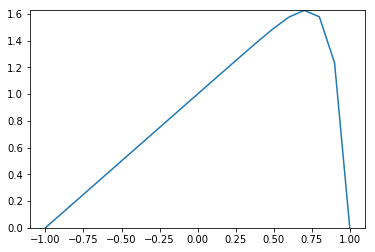

In [7]:
u = solve_transport_1dfem(20, 0.1)
uval = u.compute_vertex_values()

plot(u, range_min=min(uval), range_max=max(uval))

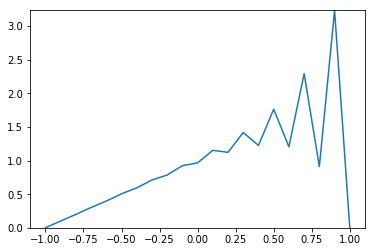

In [8]:
u = solve_transport_1dfem(20, 0.01)
uval = u.compute_vertex_values()

plot(u, range_min=min(uval), range_max=max(uval))

## Galerkin Least Squares Method ##

The Galerkin least squares (GLS) method combines Galerkin method and the least squares finite elements to stablize the solution. It can be considered as a systematic way for introducing artificial diffusion or regularization terms.

In [9]:
def solve_transport_2dfem_gls(n, epsilon, C, p=1):
    # Construct the mesh    
    domain = Rectangle(Point(-1, -1), Point(1,1))
    mesh = generate_mesh(domain,n)

    # Define trial and test functions
    V = FunctionSpace(mesh, 'P', p)
    u = TrialFunction(V)
    v = TestFunction(V)

    f = Constant(1.)
    b = Constant((1., 1.))

    # Define boundary conditions
    u0 = Constant(0)
    bc = DirichletBC(V, u0, u0_boundary)
    
    # Define variational form
    a = epsilon * dot(grad(u), grad(v)) * dx + dot(b, grad(u)) * v * dx
    L = f * v * dx

    # Note that div(grad(u))=0 for linear finite elements
    Lu = lambda u : -epsilon * div(grad(u)) + dot(b, grad(u))

    h = CellSize(mesh)
    sigma = h * Constant(C)
    a_stablized = a + sigma * Lu(u) * Lu(v) * dx
    L_stablized = L + sigma * f * Lu(v) * dx

    u = Function(V)
    solve(a_stablized == L_stablized, u, bc)
    
    return u

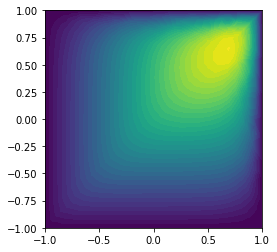

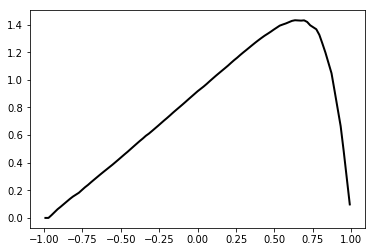

In [14]:
u = solve_transport_2dfem_gls(n=20, epsilon=0.01, C=1, p=1)
plot(u)

y, u_line = extract_diagonal(u)
plt.figure()
plt.plot(y, u_line, 'k', linewidth=2)